In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from utils.helpers import *
import keras
from keras import layers
from keras import models
from keras import optimizers
import numpy as np
from matplotlib.pyplot import imshow
%matplotlib inline
keras.__version__

Using TensorFlow backend.


'2.1.3'

In [2]:
IMAGE_ID = 5
PADDING = 47

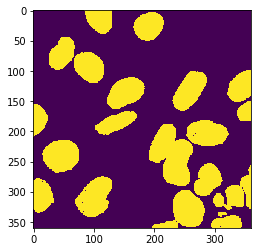

In [3]:
# Get only one image
image, mask = get_image_mask_from_id(IMAGE_ID)
image = image / 255.
# print(image.shape)
# print(mask.shape)
imshow(mask)

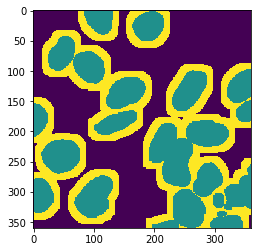

In [6]:
new_mask = from_2_mask_to_3_mask(mask,10)
imshow(new_mask)

In [7]:
# Get training input and labels from image
train, labels = get_train_test(image, mask, num_classes = 3, padding=PADDING)
print(train.shape)
print(labels.shape)

(76337, 95, 95, 3)
(76337, 3)


In [ ]:
# Split the train for cross validation
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(train, labels, test_size = 0.2)
print("TRAIN : ", train_images.shape, train_labels.shape)
print("TEST  : ", test_images.shape, test_labels.shape)

In [ ]:
import pandas as pd

data = pd.DataFrame(train_labels)
print(data[0].value_counts())
print(data[1].value_counts())
data.head()

In [11]:
# Create a Convnet
# The architecture presented intends to replicate the one described in this paper
# http://www.sbrt.org.br/sbrt2017/anais/1570355345.pdf

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(95, 95, 3), name="CONV1"))
model.add(layers.MaxPooling2D((2, 2), name="MP1"))
model.add(layers.Conv2D(64, (5, 5), activation='relu', name="CONV2"))
model.add(layers.MaxPooling2D((2, 2), name="MP2"))
model.add(layers.Conv2D(128, (5, 5), activation='relu', name="CONV3"))
model.add(layers.MaxPooling2D((2, 2), name="MP3"))
model.add(layers.Conv2D(256, (5, 5), activation='relu', name="CONV4"))
model.add(layers.Flatten(name="FLAT"))
model.add(layers.Dropout(0.5, name="D1"))
model.add(layers.Dense(200, activation='relu', name="FC1"))
model.add(layers.Dropout(0.5, name="D2"))
model.add(layers.Dense(3, activation='softmax', name="FC2"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 91, 91, 32)        2432      
_________________________________________________________________
MP1 (MaxPooling2D)           (None, 45, 45, 32)        0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 41, 41, 64)        51264     
_________________________________________________________________
MP2 (MaxPooling2D)           (None, 20, 20, 64)        0         
_________________________________________________________________
CONV3 (Conv2D)               (None, 16, 16, 128)       204928    
_________________________________________________________________
MP3 (MaxPooling2D)           (None, 8, 8, 128)         0         
_________________________________________________________________
CONV4 (Conv2D)               (None, 4, 4, 256)         819456    
__________

In [ ]:
# SGD for fitting the model
# Do not train on MAC or it will EXPLODE 
# The hyperparameters are according to the ones described on the paper

SGD = optimizers.SGD(lr=0.005, decay=1e-6, momentum=0.9)

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

In [ ]:
# Check accuracy of model
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

In [ ]:
# For saving the model
model.save('state_3_classes.h5')

In [ ]:
# For loading the model
model = models.load_model("state_3_classes.h5")

In [ ]:
# Get test cases from original image
# Might cause overload, careful
test = get_test_from_image(image, padding=PADDING)

In [ ]:
# Predict using model
predictions = model.predict(test)

In [ ]:
# Preparing to visualized predicted output
# Only valid for current model
# If model is changed, this method should change too

pred = []
for p in predictions:
    pred.append(np.argmax(p))
        
output = np.array(pred).reshape(image.shape[0], image.shape[1])
imshow(output)

In [ ]:
# new_mask = from_2_mask_to_3_mask(mask)
imshow(mask)

In [ ]:
# Save images for analyzing IoU
from PIL import Image

IMG_FOLDER = "./images"
create_folder_if_not_exists(IMG_FOLDER)

img = Image.fromarray(from_normilzed_to_image_array(image))
img.save(os.path.join(IMG_FOLDER, "image.png"))

msk = Image.fromarray(from_normilzed_to_image_array(mask))
msk.save(os.path.join(IMG_FOLDER, "mask.png"))

prd = Image.fromarray(from_normilzed_to_image_array(output))
prd.save(os.path.join(IMG_FOLDER, "prediction.png"))